<a href="https://colab.research.google.com/github/ranja-sarkar/DecisionTree/blob/main/features_RFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Features: Their importance and interactions


In [4]:
#!pip install shapiq

In [5]:
#!pip install overrides

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import missingno as msn

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

import shap
import shapiq

# Data

In [7]:
train_df = pd.read_csv('train_data.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10000 non-null  int64  
 1   profession       9507 non-null   object 
 2   age              5822 non-null   float64
 3   gender           7421 non-null   object 
 4   highestDegree    10000 non-null  object 
 5   maritalStatus    10000 non-null  object 
 6   noOfKids         5467 non-null   float64
 7   creditRisk       10000 non-null  float64
 8   otherMembership  8553 non-null   object 
 9   pastStays1y      9050 non-null   float64
 10  blogger          10000 non-null  object 
 11  articles         10000 non-null  int64  
 12  amexCard         10000 non-null  object 
 13  purposeTravel    10000 non-null  object 
 14  staySpend        10000 non-null  float64
 15  loyaltyClass     10000 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 1.2+ MB


>> **loyaltyClass" is the target here -> the task is to classify a customer into one of the 3 tiers of loyalty.

In [8]:
raw = train_df.copy()    # multiclass labelled data

In [37]:
raw.head(3)

,ID,profession,age,gender,highestDegree,maritalStatus,noOfKids,creditRisk,otherMembership,pastStays1y,blogger,articles,amexCard,purposeTravel,staySpend,loyaltyClass
0,0,Public Sector,NaN,Male,High School Equivalent,Single,0.0,3.18,IHG,23.0,No,7,Yes,Medical Tourism,1433.147527,Bronze
1,1,Private Sector,NaN,NaN,Associate Degree,Married,1.0,2.07,IHG,48.0,No,4,Yes,Leisure Travel,38.379023,Silver
2,2,Business,44.0,Female,Masters Degree,Married,NaN,2.81,Discovery,32.0,No,1,No,Leisure Travel,0.000000,Bronze


In [9]:
feature_names = list(raw.columns)

>> **Handling missing values**

In [10]:
train_df['age'].fillna(train_df['age'].mean(), inplace = True)
train_df['noOfKids'].fillna(0, inplace = True)
train_df['pastStays1y'].fillna(0, inplace = True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10000 non-null  int64  
 1   profession       9507 non-null   object 
 2   age              10000 non-null  float64
 3   gender           7421 non-null   object 
 4   highestDegree    10000 non-null  object 
 5   maritalStatus    10000 non-null  object 
 6   noOfKids         10000 non-null  float64
 7   creditRisk       10000 non-null  float64
 8   otherMembership  8553 non-null   object 
 9   pastStays1y      10000 non-null  float64
 10  blogger          10000 non-null  object 
 11  articles         10000 non-null  int64  
 12  amexCard         10000 non-null  object 
 13  purposeTravel    10000 non-null  object 
 14  staySpend        10000 non-null  float64
 15  loyaltyClass     10000 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 1.2+ MB


/tmp/ipython-input-75524796.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['age'].fillna(train_df['age'].mean(), inplace = True)
/tmp/ipython-input-75524796.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

>> **Label encoding categorical variables**

In [11]:
le = LabelEncoder()

train_df['profession'] = le.fit_transform(train_df['profession']).astype('str')
train_df['gender'] = le.fit_transform(train_df['gender']).astype('str')
train_df['otherMembership'] = le.fit_transform(train_df['otherMembership']).astype('str')

train_df['highestDegree'] = le.fit_transform(train_df['highestDegree']).astype('str')
train_df['maritalStatus'] = le.fit_transform(train_df['maritalStatus']).astype('str')
train_df['blogger'] = le.fit_transform(train_df['blogger']).astype('str')
train_df['amexCard'] = le.fit_transform(train_df['amexCard']).astype('str')
train_df['purposeTravel'] = le.fit_transform(train_df['purposeTravel']).astype('str')
train_df['loyaltyClass'] = le.fit_transform(train_df['loyaltyClass']).astype('str')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10000 non-null  int64  
 1   profession       10000 non-null  object 
 2   age              10000 non-null  float64
 3   gender           10000 non-null  object 
 4   highestDegree    10000 non-null  object 
 5   maritalStatus    10000 non-null  object 
 6   noOfKids         10000 non-null  float64
 7   creditRisk       10000 non-null  float64
 8   otherMembership  10000 non-null  object 
 9   pastStays1y      10000 non-null  float64
 10  blogger          10000 non-null  object 
 11  articles         10000 non-null  int64  
 12  amexCard         10000 non-null  object 
 13  purposeTravel    10000 non-null  object 
 14  staySpend        10000 non-null  float64
 15  loyaltyClass     10000 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 1.2+ MB


loyaltyClass
Silver    5665
Bronze    3998
Gold       337
Name: count, dtype: int64
-----
loyaltyClass
2    5665
0    3998
1     337
Name: count, dtype: int64
-----


Text(0.5, 0, 'loyaltyClass')

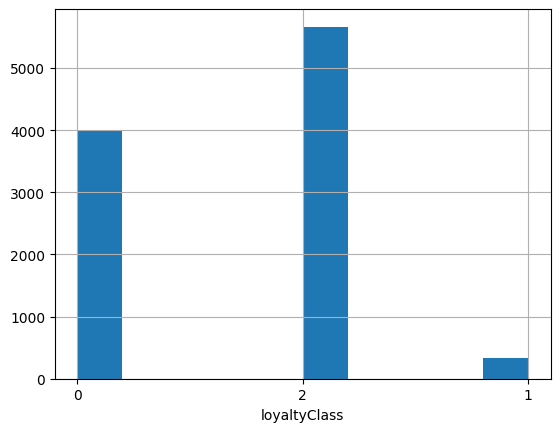

In [12]:
print(raw['loyaltyClass'].value_counts())
print('-----')
print(train_df['loyaltyClass'].value_counts())
print('-----')

train_df['loyaltyClass'].hist()
plt.xlabel('loyaltyClass')

> **Feature Scaling**

>>  https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html


In [13]:
cols = feature_names.remove('loyaltyClass')

xx = train_df.loc[:, train_df.columns != 'loyaltyClass'].values
minmax_scaler = preprocessing.MinMaxScaler()
x_scaled = minmax_scaler.fit_transform(xx)

df = pd.DataFrame(data = x_scaled, columns = cols)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0000,0.50,0.502392,0.5,0.428571,0.666667,0.00,0.726667,0.5,0.469388,0.0,0.35,1.0,1.0,0.018969
1,0.0001,0.25,0.502392,1.0,0.000000,0.333333,0.25,0.356667,0.5,0.979592,0.0,0.20,1.0,0.5,0.000508
2,0.0002,0.00,0.619048,0.0,0.714286,0.333333,0.00,0.603333,0.0,0.653061,0.0,0.05,0.0,0.5,0.000000


In [14]:
data = df.copy()      #saving scaled data

In [15]:
df.columns = train_df.columns[0:15]
df.head(5)

,ID,profession,age,gender,highestDegree,maritalStatus,noOfKids,creditRisk,otherMembership,pastStays1y,blogger,articles,amexCard,purposeTravel,staySpend
0,0.0000,0.50,0.502392,0.5,0.428571,0.666667,0.00,0.726667,0.500000,0.469388,0.0,0.35,1.0,1.0,0.018969
1,0.0001,0.25,0.502392,1.0,0.000000,0.333333,0.25,0.356667,0.500000,0.979592,0.0,0.20,1.0,0.5,0.000508
2,0.0002,0.00,0.619048,0.0,0.714286,0.333333,0.00,0.603333,0.000000,0.653061,0.0,0.05,0.0,0.5,0.000000
3,0.0003,0.50,0.502392,0.5,0.142857,0.666667,0.00,0.820000,0.500000,0.122449,0.0,0.80,1.0,1.0,0.000000
4,0.0004,0.00,0.502392,0.0,0.142857,1.000000,0.00,0.736667,0.833333,0.000000,1.0,0.00,0.0,0.0,0.010118


In [16]:
dff = pd.concat([df, train_df['loyaltyClass']], axis = 1)
#list(dff.columns)[0:16]

In [17]:
X = dff[list(dff.columns)[0:15]]
Y = dff[list(dff.columns)[-1]]

> **Data splitting**

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)   # 75% train size default

>> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [19]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)  #default
rfc.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

# Feature Importance by MDI (mean decrease in impurity)

>> The impurity-based feature importance ranks the numerical features to be the most important.

>> Impurity-based importances are biased towards high cardinality features.

>> They are computed on training dataset statistics and therefore do not reflect the ability of features useful to make predictions that generalize to the test set (when the model has enough capacity) that is, importances can be high even for features that are not predictive of the target, as long as the model has the capacity to use them to overfit.

-- Explains why ID is shown to be the most important here (inflated the importance of numerical feature).

Text(0.5, 1.0, 'Feature Importance (MDI)')

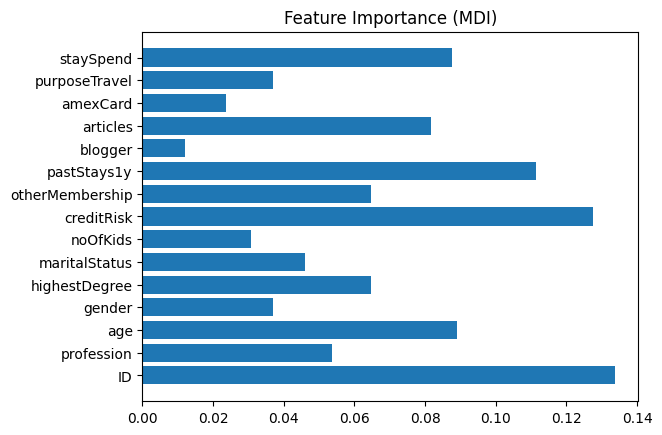

In [20]:
feats = list(train_df.columns)[0:15]

plt.barh(feats, rfc.feature_importances_)
plt.title ('Feature Importance (MDI)')

# Features by Permutation Importance

>> The permutation importances of the random forest algorithm are computed on a held out test dataset.

>> Permuting the values of the most important features (categorical ones e.g. maritalStatus, profession) will lead to the most decrease in model accuracy (score) on the test set.

> https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html


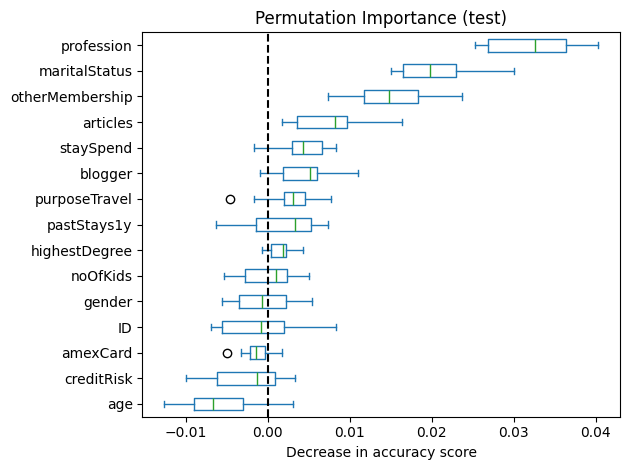

In [23]:
result = permutation_importance(
    rfc, x_test, y_test, n_repeats = 10, random_state = 42, n_jobs = 2)

sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert = False)
ax.set_title("Permutation Importance (test)")
ax.axvline(x = 0, color = "k", linestyle = "--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

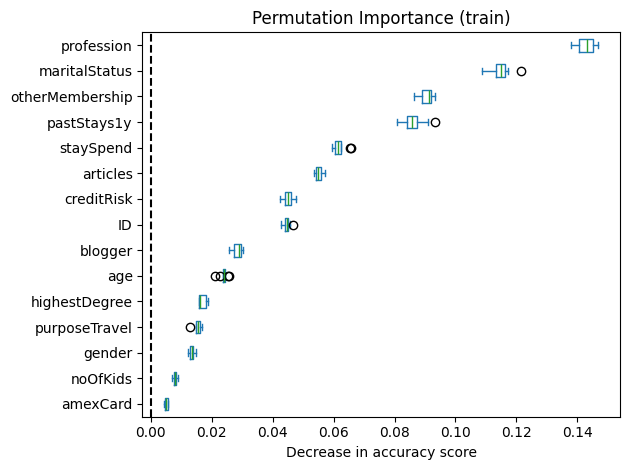

In [24]:
result = permutation_importance(
    rfc, x_train, y_train, n_repeats = 10, random_state = 42, n_jobs = 2)


sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert = False)
ax.set_title("Permutation Importance (train)")
ax.axvline(x = 0, color = "k", linestyle = "--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


>> The difference between the test and train feature importance plots is a confirmation that random forest has enough capacity to use numerical and categorical features to overfit.

In [25]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

> How do you limit the capacity of the (ensemble) trees to overfit?

> Tune the hyperparameter -> min_samples_leaf

In [31]:
rfc = RandomForestClassifier(min_samples_leaf = 40, random_state = 42)
rfc.fit(x_train, y_train)

RandomForestClassifier(min_samples_leaf=40, random_state=42)

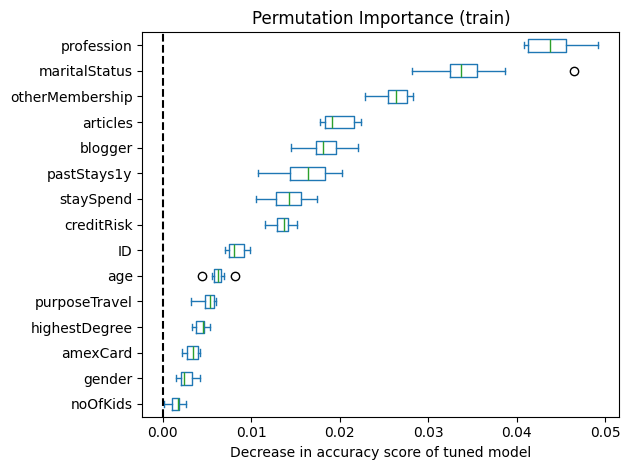

In [32]:
result = permutation_importance(
    rfc, x_train, y_train, n_repeats = 10, random_state = 42, n_jobs = 2)


sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert = False)
ax.set_title("Permutation Importance (train)")
ax.axvline(x = 0, color = "k", linestyle = "--")
ax.set_xlabel("Decrease in accuracy score of tuned model")
ax.figure.tight_layout()

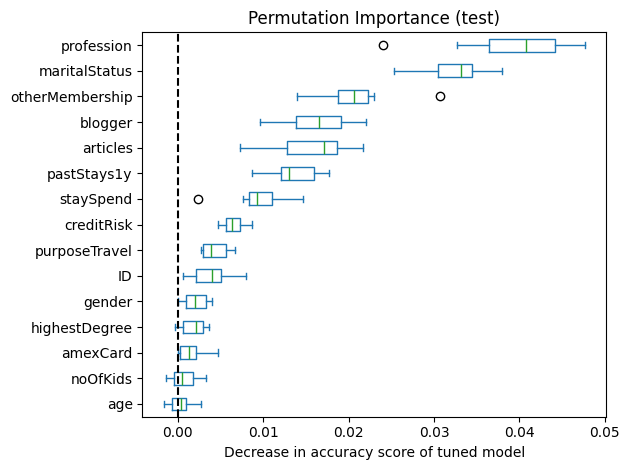

In [33]:
result = permutation_importance(
    rfc, x_test, y_test, n_repeats = 10, random_state = 42, n_jobs = 2)

sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert = False)
ax.set_title("Permutation Importance (test)")
ax.axvline(x = 0, color = "k", linestyle = "--")
ax.set_xlabel("Decrease in accuracy score of tuned model")
ax.figure.tight_layout()

>> We observe that on both sets, the categorical variables such as gender, amexCard, highestDegree have lower importances.

>> We observe that the metric - model accuracy score are very similar for both sets, pointing that the RF model is not overfitting.

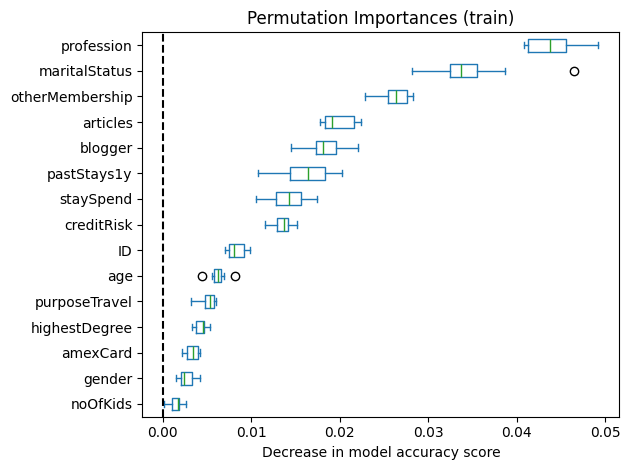

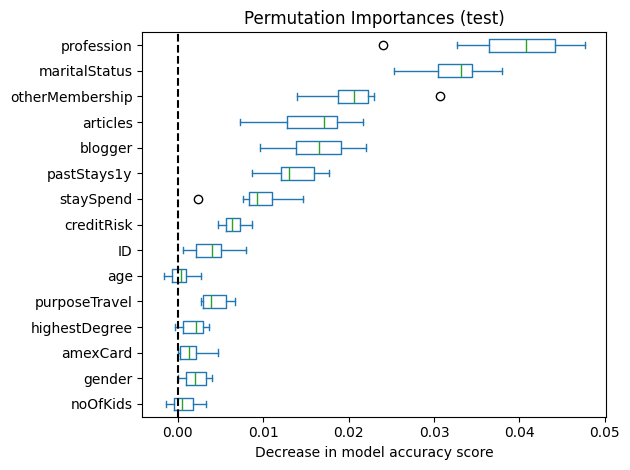

In [36]:
#putting them all together

train_result = permutation_importance(
    rfc, x_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
test_result = permutation_importance(
    rfc, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_importances_idx = train_result.importances_mean.argsort()


train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
    )
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
    )

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert = False)
    ax.set_title(f"Permutation Importances ({name})")
    ax.set_xlabel("Decrease in model accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

In [38]:
print(rfc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 40, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


#  Features by SHAP

>> https://github.com/shap/shap


In [ ]:
xplainer = shap.TreeExplainer(rfc)   #with the default model

In [ ]:
shap_values = xplainer.shap_values(x_train)
shap_values.shape

(7000, 15, 3)

>> Computation of SHAPley values is time-consuming.

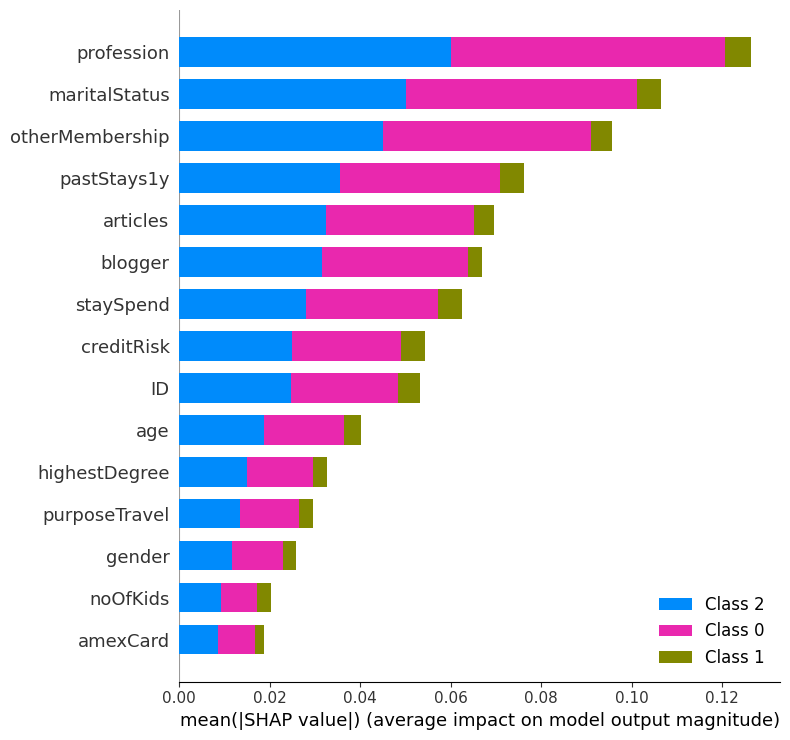

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type = "bar")     #class 1 is Gold tier of customers

In [ ]:
#x_train.mean()

shap_values[0]         #first sample/example

array([[-2.12426600e-02, -2.41952837e-03,  2.36621884e-02],
       [-7.69284299e-02, -2.82218824e-04,  7.72106487e-02],
       [-2.30244045e-02, -2.48321444e-03,  2.55076189e-02],
       [-1.08133397e-02, -1.44321710e-03,  1.22565568e-02],
       [-4.57121162e-03, -1.73694363e-03,  6.30815525e-03],
       [ 4.17882471e-02, -1.86311307e-03, -3.99251340e-02],
       [-3.23991804e-03, -8.50747264e-04,  4.09066531e-03],
       [-4.64175263e-02, -6.77463784e-04,  4.70949901e-02],
       [ 4.43152995e-02, -9.55783547e-03, -3.47574641e-02],
       [ 1.39777620e-02, -7.82408280e-03, -6.15367916e-03],
       [ 1.77069881e-02, -1.90026956e-03, -1.58067186e-02],
       [-1.07724049e-02, -4.33219734e-03,  1.51046023e-02],
       [-1.06327113e-02,  1.23605056e-03,  9.39666075e-03],
       [-4.42967966e-02,  5.80260087e-05,  4.42387706e-02],
       [-4.52260366e-02,  3.59612212e-04,  4.48664244e-02]])

>> https://shap.readthedocs.io/en/latest/api.html#plots

>> https://shap.readthedocs.io/en/latest/generated/shap.plots.partial_dependence.html

# PDPs

> Partial Dependence Plots (PDPs) for multi-class classifiers allows for visualizing the marginal effect of one (or more) features on the predicted outcome of the classifier, specifically for a chosen class.

> PDPs with scikit-learn: https://scikit-learn.org/stable/modules/partial_dependence.html


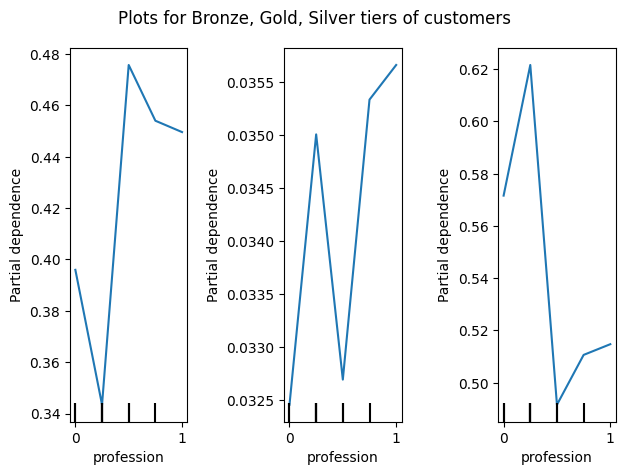

In [39]:
fig, ax = plt.subplots(ncols = 3)
PartialDependenceDisplay.from_estimator(rfc, x_test, ['profession'], target = rfc.classes_[0], ax = ax[0])
PartialDependenceDisplay.from_estimator(rfc, x_test, ['profession'], target = rfc.classes_[1], ax = ax[1])
PartialDependenceDisplay.from_estimator(rfc, x_test, ['profession'], target = rfc.classes_[2], ax = ax[2])
plt.suptitle("Plots for Bronze, Gold, Silver tiers of customers")
plt.tight_layout()
plt.show()

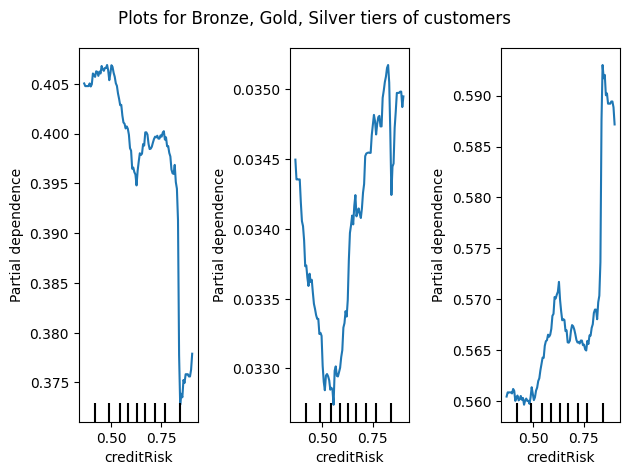

In [40]:
fig, ax = plt.subplots(ncols = 3)
PartialDependenceDisplay.from_estimator(rfc, x_test, ['creditRisk'], target = rfc.classes_[0], ax = ax[0])
PartialDependenceDisplay.from_estimator(rfc, x_test, ['creditRisk'], target = rfc.classes_[1], ax = ax[1])
PartialDependenceDisplay.from_estimator(rfc, x_test, ['creditRisk'], target = rfc.classes_[2], ax = ax[2])
plt.suptitle("Plots for Bronze, Gold, Silver tiers of customers")
plt.tight_layout()
plt.show()

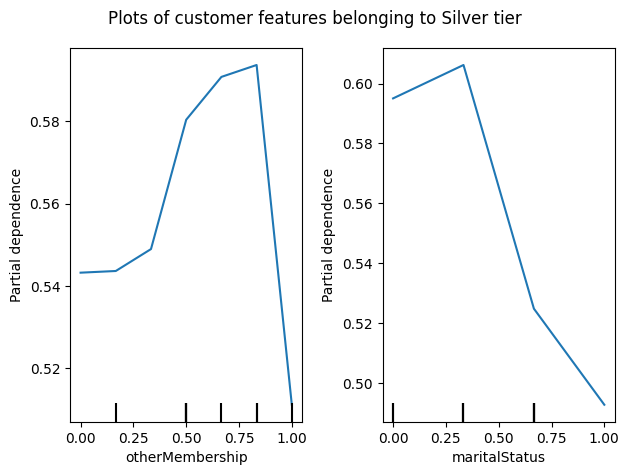

In [41]:
fig, ax = plt.subplots(ncols = 2)       #figsize = (,)
PartialDependenceDisplay.from_estimator(rfc, x_test, ['otherMembership'], target = rfc.classes_[2], ax = ax[0])
PartialDependenceDisplay.from_estimator(rfc, x_test, ['maritalStatus'], target = rfc.classes_[2], ax = ax[1])
plt.suptitle("Plots of customer features belonging to Silver tier")
plt.tight_layout()
plt.show()

# Features by SHAPIQ

>> https://github.com/mmschlk/shapiq

In [ ]:
data = pd.concat([data, train_df['loyaltyClass']], axis = 1)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,loyaltyClass
0,0.0000,0.50,0.502392,0.5,0.428571,0.666667,0.00,0.726667,0.5,0.469388,0.0,0.35,1.0,1.0,0.018969,0
1,0.0001,0.25,0.502392,1.0,0.000000,0.333333,0.25,0.356667,0.5,0.979592,0.0,0.20,1.0,0.5,0.000508,2
2,0.0002,0.00,0.619048,0.0,0.714286,0.333333,0.00,0.603333,0.0,0.653061,0.0,0.05,0.0,0.5,0.000000,0


In [ ]:
X = data[list(data.columns)[0:15]]
Y = data[list(data.columns)[-1]]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42)

rfc = RandomForestClassifier(random_state = 42)    #default
rfc.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
explainer = shapiq.TabularExplainer(
    model = rfc,
    data = np.array(x_train),
    index = "k-SII",          #interaction upto order 3
    max_order = 3)

>> Higher-order interactions can also be calculated with built-in approximators.

In [ ]:
interaction_values = explainer.explain(x_train[:1], budget = 256)   #explain the first record/observation/sample/example
print(interaction_values)

InteractionValues(
    index=k-SII, max_order=3, min_order=0, estimated=True, estimation_budget=256,
    n_players=15, baseline_value=0.03473866666666667,
    Top 10 interactions:
        (): 0.03473866666666667
        (14,): -0.014871975772552887
        (12,): -0.02100057243401835
        (13,): -0.02212165264497088
        (4,): -0.02222400861334842
        (9,): -0.022415160780584607
        (6,): -0.022977958036385922
        (1,): -0.02409914786571943
        (7,): -0.02544113517480258
        (3,): -0.02907016181423671
)


In [ ]:
interaction_values

InteractionValues(
    index=k-SII, max_order=3, min_order=0, estimated=True, estimation_budget=256,
    n_players=15, baseline_value=0.03473866666666667
)

In [ ]:
#interaction_values.plot_network(feature_names =  x_train.columns)
#interaction_values.plot_waterfall()

#shapiq.plot.force_plot(interaction_values, feature_names = x_train.columns, show = True)

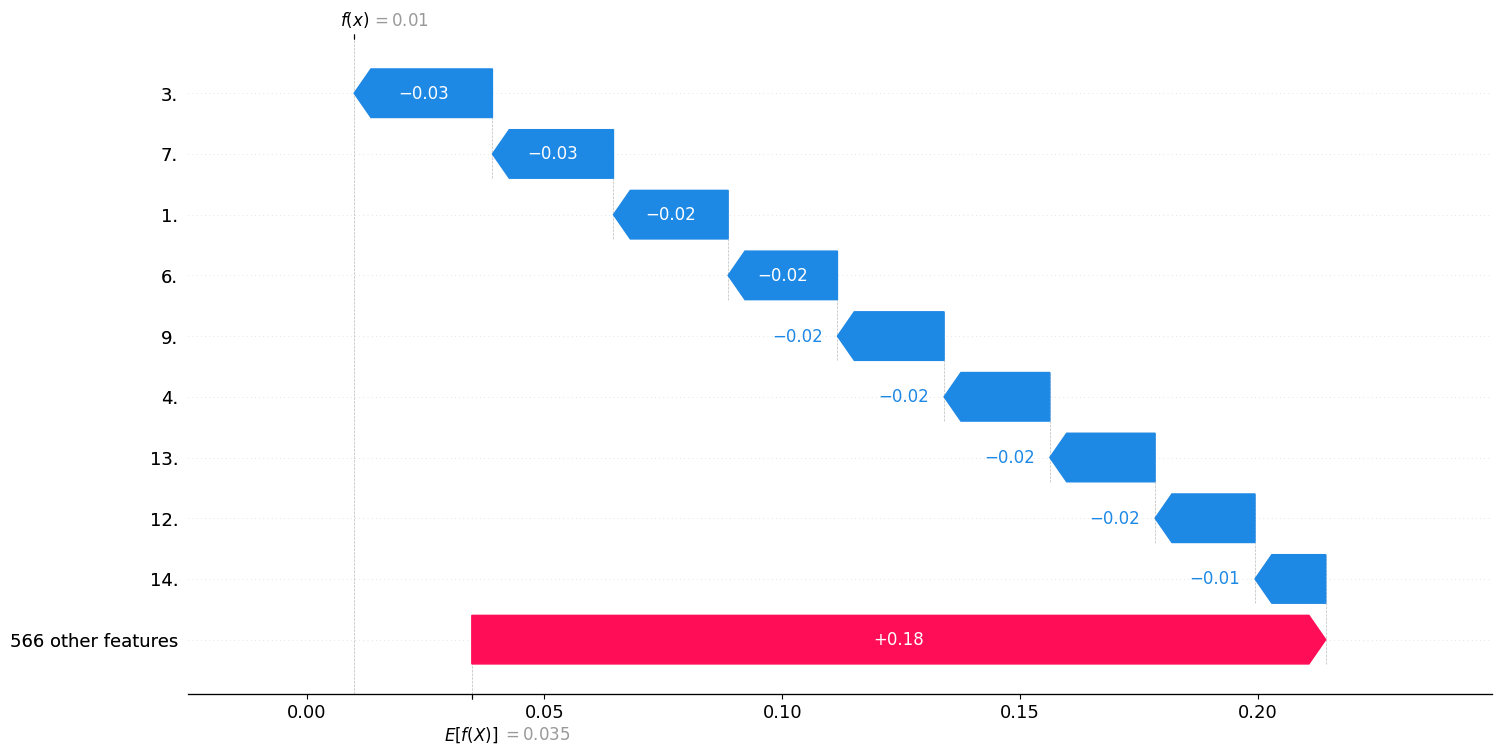

In [ ]:
shapiq.waterfall_plot(interaction_values, feature_names = x_train.columns, show = True)

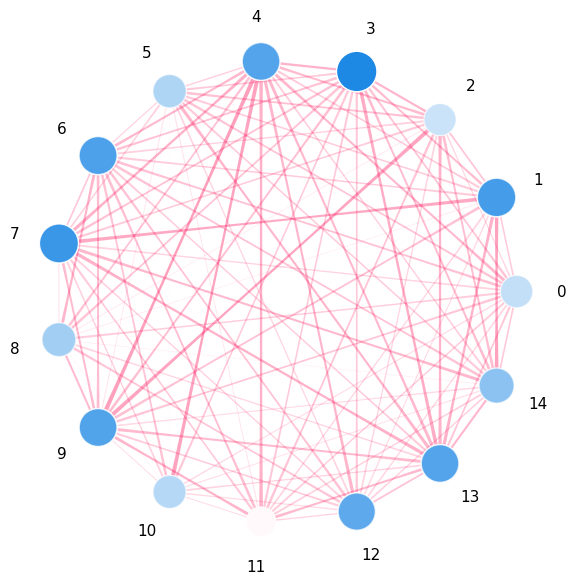

In [ ]:
shapiq.network_plot(interaction_values)
plt.show()

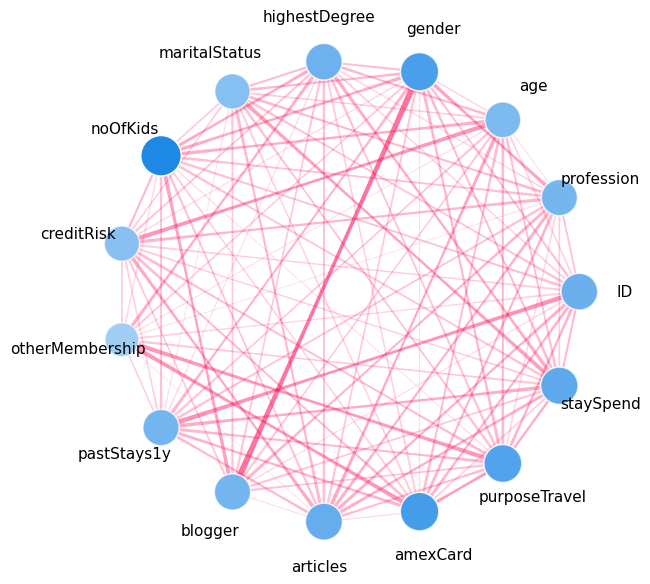

In [ ]:
shapiq.network_plot(interaction_values, feature_names = x_train.columns)
plt.show()

>> https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.network.html
